In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
!nvidia-smi

Sun Aug 31 09:07:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.76.04              Driver Version: 580.97         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   61C    P5             29W /  139W |    7117MiB /   8192MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:


# Set the seed for reproducibility. Don't forget to comment out this line when averaging over different runs
#torch.manual_seed(42)

# Convert data to torch.FloatTensor
transform = transforms.ToTensor()


train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# Select only a part of the dataset to speed up training times
num_train_samples = 50000
num_test_samples = 5000

# Randomly select a subset of samples
train_indices = torch.randperm(len(train_data))[:num_train_samples]
test_indices = torch.randperm(len(test_data))[:num_test_samples]

# Create subset samplers to be used in the dataloader
train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)



In [4]:
# Choose how many samples per batch to load
# You can tune the batch size
batch_size = 32

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler = train_subset_sampler,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          sampler = test_subset_sampler,
                                          num_workers=0)

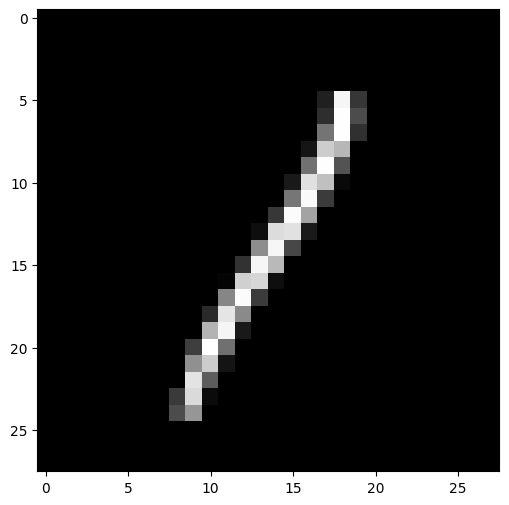

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain one batch of training images
images, labels = next(iter(train_loader)) # iter() creates an iterator over the batches in the dataloader and next() selects the next batch from this iterator.
images = images.numpy() #.numpy() turns the torch.tensor into a numpy array

# Get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

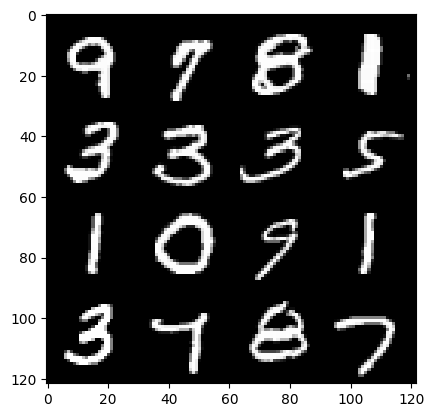

In [6]:
# package we used to manipulate matrix
import numpy as np
# package we used for image processing
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load the first 16 training samples from next iteration
# [:16,:,:,:] for the 4 dimension of examples, first dimension take first 16, other dimension take all data
# arrange the image in grid
examples, _ = next(iter(train_loader))
example_show=make_grid(examples[:16,:,:,:], 4)

# then display them
imshow(example_show)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# Define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(784, encoding_dim)
        # Decoder
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        # Define feedforward behavior
        # and scale the *output* layer with a sigmoid activation function

        # Pass x into encoder
        out = F.relu(self.encoder(x))
        # Pass out into decoder
        out = torch.sigmoid(self.decoder(out))

        return out

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)


# Building the encoder
class Autoencoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2):
        super(Autoencoder, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        # decoder part
        self.fc3 = nn.Linear(h_dim2, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def decoder(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# When initialzing, it will run __init__() function as above
model = Autoencoder(num_input, num_hidden_1, num_hidden_2)
# If using GPU, model need to be set on cuda()
model.cuda()

Autoencoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
)

In [21]:
# Initialize the NN
# You can change the encoding_dim to obtain models with different size
encoding_dim = 32
model = Autoencoder(encoding_dim)

# Send model to GPU if available
if torch.cuda.is_available():
  model.cuda()
print(model)

Autoencoder(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)


In [8]:
# Specify the loss function
criterion = nn.MSELoss()

# We use Adam as the optimizer with a fixed learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Choose the number of Epochs to train the network
n_epochs = 20
# Set model to training mode
model.train()

for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0

    # Train the model #
    # Feed the data into the network batch by batch using the dataloader
    for batch_data in train_loader:
        # _ stands in for labels
        # we do not need labels when conducting reconstruction
        images, _ = batch_data
        # Flatten images and send images to GPU
        images = images.view(images.size(0), -1)
        # Send images to GPU if possible
        if torch.cuda.is_available():
          images = images.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss between output and input images
        loss = criterion(outputs, images)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()*images.size(0)

    # Print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))




Epoch: 0 	Training Loss: 1.604970
Epoch: 1 	Training Loss: 0.889229
Epoch: 2 	Training Loss: 0.637084
Epoch: 3 	Training Loss: 0.504644
Epoch: 4 	Training Loss: 0.418917
Epoch: 5 	Training Loss: 0.360928
Epoch: 6 	Training Loss: 0.322113
Epoch: 7 	Training Loss: 0.292469
Epoch: 8 	Training Loss: 0.268561
Epoch: 9 	Training Loss: 0.248825
Epoch: 10 	Training Loss: 0.232582
Epoch: 11 	Training Loss: 0.219397
Epoch: 12 	Training Loss: 0.207567
Epoch: 13 	Training Loss: 0.197488
Epoch: 14 	Training Loss: 0.188113
Epoch: 15 	Training Loss: 0.179714
Epoch: 16 	Training Loss: 0.172169
Epoch: 17 	Training Loss: 0.165888
Epoch: 18 	Training Loss: 0.160133
Epoch: 19 	Training Loss: 0.154747


In [9]:
# Set model to evaluation mode
model.eval()

# Monitor test loss
test_loss = 0.0

# Disable gradient computation
with torch.no_grad():
    # Iterate over the test data
    for batch_data in test_loader:
        # Extract images from the batch
        images, _ = batch_data
        # Flatten images and send them to GPU
        images = images.view(images.size(0), -1)
        # Send to GPU
        if torch.cuda.is_available():
          images = images.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss between output and input images
        loss = criterion(outputs, images)
        # Update test loss
        test_loss += loss.item()*images.size(0)

# Compute average test loss
test_loss = test_loss/len(test_loader)

# Print test loss
print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 0.150143


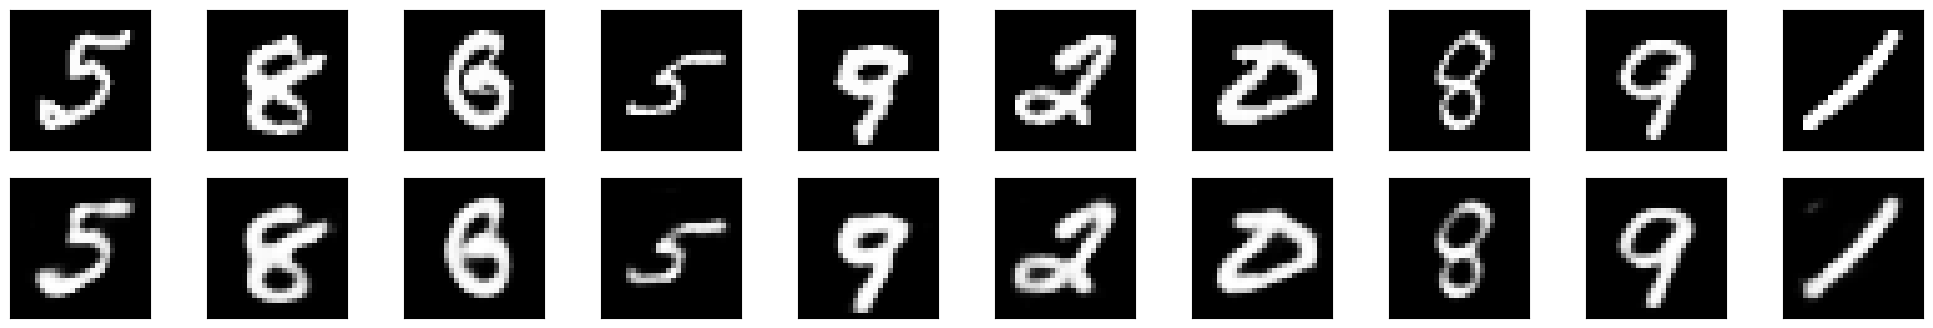

In [10]:
# Obtain one batch of test images
test_images, test_labels = next(iter(test_loader))

test_images_flatten = test_images.view(test_images.size(0), -1)
# Set model to evaluation mode
model.eval()
# Send model back to CPU
model.cpu()
# Get sample outputs
output = model(test_images_flatten)
# Prep images for display
test_images = test_images.numpy()

# Output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.detach().numpy()

# Plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# Input images on top row, reconstructions on bottom
for test_images, row in zip([test_images, output], axes):
    for img, ax in zip(test_images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

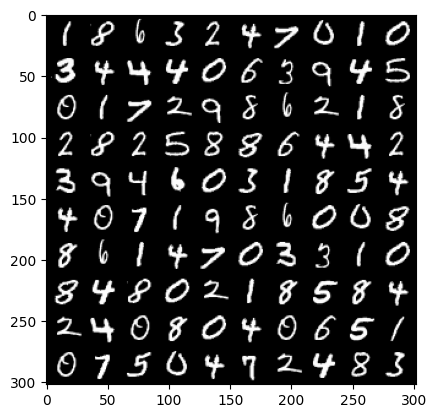

tensor([[1, 8, 6, 3, 2, 4, 7, 0, 1, 0],
        [3, 4, 4, 4, 0, 6, 3, 9, 4, 5],
        [0, 1, 7, 2, 9, 8, 6, 2, 1, 8],
        [2, 8, 2, 5, 8, 8, 6, 4, 4, 2],
        [3, 9, 4, 6, 0, 3, 1, 8, 5, 4],
        [4, 0, 7, 1, 9, 8, 6, 0, 0, 8],
        [8, 6, 1, 4, 7, 0, 3, 3, 1, 0],
        [8, 4, 8, 0, 2, 1, 8, 5, 8, 4],
        [2, 4, 0, 8, 0, 4, 0, 6, 5, 1],
        [0, 7, 5, 0, 4, 7, 2, 4, 8, 3]])


In [11]:

# get 100 image-label pairs from training set
x_train, y_train = next(iter(train_loader))

# 10 classes, 10 samples per class, 100 in total
candidates = np.random.choice(batch_size, 10*10)

# randomly select 100 samples
x_train = x_train[candidates]
y_train = y_train[candidates]

# display the selected samples and print their labels

imshow(make_grid(x_train[:100,:,:,:],10))
print(y_train.reshape(10, 10))



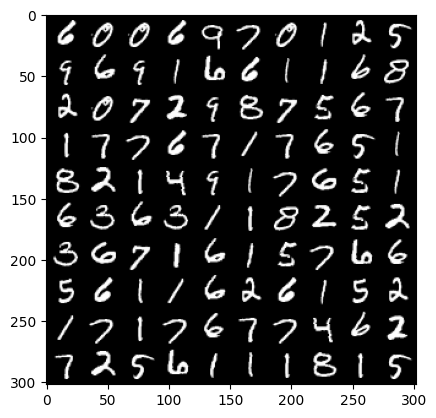

In [13]:
# get 100 image-label pairs from test set
x_test, y_test = next(iter(train_loader))
candidates_test = np.random.choice(batch_size, 10*10)

x_test = x_test[candidates_test]
y_test = y_test[candidates_test]

# display the selected samples and print their labels
imshow(make_grid(x_test[:100,:,:,:],10))



In [14]:
# compute the representations of training and test samples
h_train=model.encoder(torch.reshape(x_train,(-1,784)))
h_test=model.encoder(torch.reshape(x_test,(-1,784)))

# find the nearest training samples to each test instance, in terms of MSE
MSEs = np.mean(np.power(np.expand_dims(h_test.detach().cpu(), axis=1) - np.expand_dims(h_train.detach().cpu(), axis=0), 2), axis=2)
neighbours = MSEs.argmin(axis=1)
predicts = y_train[neighbours]

# print(np.stack([y_test, predicts], axis=1))
print('Recognition accuracy according to the learned representation is %.1f%%' % (100 * (y_test == predicts).numpy().astype(np.float32).mean()))

Recognition accuracy according to the learned representation is 82.0%
